# Computational Performance

In this notebook we compare the compuational performance of the `EFTEMU` to that of `PyBird`. To do this comparison we will be using the built-in magin command `timeit`. We will be making predictions with both the `EFTEMU` and `PyBird` 100 times and calculating the mean and standard deviation of the prediction time per multipole.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matryoshka.emulator as MatEmu
from classy import Class
import pybird

path_to_repo = "/Users/jamie/Desktop/GitHubProjects/matryoshka_II_paper/"

2022-02-09 11:56:05.137488: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-02-09 11:56:05.137510: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Documentation for the `timeit` command can be found [here](https://ipython.readthedocs.io/en/stable/interactive/magics.html). To use it to time `PyBird` we define a function that takes bias parameters and predicts the multipoles for a fixed cosmology and at a fixed redshift.

In [2]:
def pybird_power(bs):
    
    c2 = np.copy(bs[1])
    c4 = np.copy(bs[3])
    
    bs[1] = (c2+c4)/np.sqrt(2)
    bs[3] = (c2-c4)/np.sqrt(2)

    M.set({'ln10^{10}A_s': 3.047,
           'n_s': 0.9665,
           'h': 0.6766,
           'omega_b': 0.02242,
           'omega_cdm': 0.11933,
          })
    M.compute()

    Pk = [M.pk(ki*M.h(), zpk)*M.h()**3 for ki in kk]

    f = M.scale_independent_growth_factor_f(zpk)

    bird = pybird.Bird(kk, Pk, f, z=zpk, which='all', co=common)

    nonlinear.PsCf(bird)
    bird.setPsCfl()
    resum.Ps(bird)
    
    b1, b2, b3, b4, b5, b6, b7 = bs
    
    
    b11 = np.array([ b1**2, 2.*b1*f, f**2 ])
    bct = np.array([ 2.*b1*b5, 2.*b1*b6, 2.*b1*b7, 2.*f*b5, 2.*f*b6, 2.*f*b7 ])
    bloop = np.array([ 1., b1, b2, b3, b4, b1*b1, b1*b2, b1*b3, b1*b4, b2*b2, b2*b4, b4*b4 ])
    lin = np.einsum('b,lbx->lx', b11, bird.P11l)
    loop = np.einsum('b,lbx->lx', bloop, bird.Ploopl) 
    counterterm = np.einsum('b,lbx->lx', bct, bird.Pctl)
    ravenPs = lin + loop + counterterm
    
    return ravenPs[0], ravenPs[1]

We do all the set-up for `CLASS` and `PyBird` outside the function as it only needs to be done once.

In [3]:
M = Class()
M.set({'output': 'mPk',
       'P_k_max_1/Mpc': 1.0,
       'z_max_pk': 0.61})
common = pybird.Common(optiresum=False)
nonlinear = pybird.NonLinear(load=True, save=True, co=common)
resum = pybird.Resum(co=common)
kk = np.logspace(-5, 0, 200)
zpk=0.61

We will be using the best-fit LOWZ NGC bias parameters. However these values don't really matter for this test.

In [4]:
bs_LOWZ = np.array([1.73, 1.0, -1.0, 0.0, 0.2, -10.03, 0.])

Now we time `PyBird`,

In [5]:
pybird_time = %timeit -o -q -n 1 -r 100 pybird_power(bs_LOWZ)

the option `-o` saves the result, `-q` prevents the result being printed, using `-n 1` and `-r 100` means we make the prediction once and repeat this 100 time.

We divide the mean and standard deviation calculated by 2 as the `pybird_power` function calculates both $P_0$ and $P_2$.

In [6]:
pybird_time.average/2, pybird_time.stdev/2

(1.0128214647353162, 0.013293708143472372)

We now initalise the $P_0$ part of the `EFTEMU`.

In [7]:
P0_emu = MatEmu.EFT(0, redshift=0.61, version='EFT')

2022-02-09 11:59:30.056329: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-02-09 11:59:30.056361: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-02-09 11:59:30.056380: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (localhost.localdomain): /proc/driver/nvidia/version does not exist
2022-02-09 11:59:30.056607: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


We reshape the inputs,

In [8]:
cosmo = np.array([0.11933, 0.02242, 0.6766, 3.047, 0.9665]).reshape(1,-1)
bs_LOWZ = bs_LOWZ.reshape(1,-1)

and time time the `EFTEMU`.

In [9]:
EFTEMU_time_single = %timeit -o -n 1 -r 100 P0_emu.emu_predict(cosmo, bs_LOWZ)

4.22 ms ± 474 µs per loop (mean ± std. dev. of 100 runs, 1 loop each)


We now time the `EFTEMU` when making predictions on a batch. We load the list of cosmologies we used for training and will be selecting from it when making the batch predictions.

In [10]:
cosmo_list = np.load(path_to_repo+"data/training/cosmologies/eft_cosmologies_noDQ1.npy")

We will be starting with a batch size of $N=20$ so we repeat the bias parameters 20 times.

In [11]:
bs_stack = np.vstack(20*[bs_LOWZ])

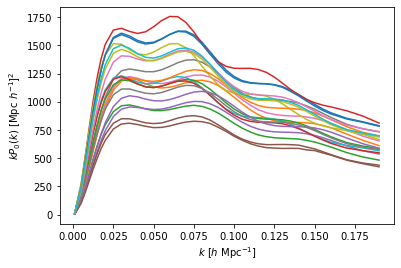

In [12]:
P0_preds = P0_emu.emu_predict(cosmo_list[:20], bs_stack)
plt.figure()
plt.plot(P0_emu.P11.kbins, (P0_emu.P11.kbins*P0_preds).T)
plt.xlabel(r"$k\ [h\ \mathrm{Mpc}^{-1}]$")
plt.ylabel(r"$kP_0(k)\ [\mathrm{Mpc}\ h^{-1}]^2$")
plt.show()

Now we time the `EFTEMU` again,

In [13]:
bs_stack = np.vstack(20*[bs_LOWZ])
EFTEMU_time_batch1 = %timeit -o -q -n 1 -r 100 P0_emu.emu_predict(cosmo_list[:20], bs_stack)

and divide the results by 20 to get the time per prediction.

In [14]:
EFTEMU_time_batch1.average/20, EFTEMU_time_batch1.stdev/20

(0.0002801134023902705, 4.608148039128081e-05)

Now we try with a batch of $N=100$.

In [15]:
bs_stack = np.vstack(100*[bs_LOWZ])
EFTEMU_time_batch2 = %timeit -o -q -n 1 -r 100 P0_emu.emu_predict(cosmo_list[:100], bs_stack)

In [16]:
EFTEMU_time_batch2.average/100, EFTEMU_time_batch2.stdev/100

(0.00010404801680124364, 8.118141364005163e-06)

To quantify the speed-up when using the `EFTEMU` we compute the ratio of the `PyBird` and `EFTEMU` prediction times $R=t_\texttt{PyBird}\ / \ t_\texttt{EFTEMU}$.

We propogate the errors on these quantities assuming there is zero correlation between them.

$$
\begin{align}
\sigma_R^2 &= \left(\frac{\delta R}{\delta t_\texttt{PyBird}} \sigma_{t_\texttt{PyBird}}\right)^2 + \left(\frac{\delta R}{\delta t_\texttt{EFTEMU}} \sigma_{t_\texttt{EFTEMU}}\right)^2\\
&=\frac{\sigma_{t_\texttt{PyBird}}^2}{t_\texttt{EFTEMU}^2}+\frac{t_\texttt{PyBird}^2}{t_\texttt{EFTEMU}^4}\sigma_{t_\texttt{PyBird}}^2\\
&=R^2\left(\frac{\sigma_{t_\texttt{PyBird}}^2}{t_\texttt{PyBird}^2}+\frac{\sigma_{t_\texttt{EFTEMU}}^2}{t_\texttt{EFTEMU}^2}\right)
\end{align}
$$

In [17]:
def prop_err(alpha, beta, sig_alpha, sig_beta):
    R = alpha/beta
    sig = (sig_alpha/alpha)**2 + (sig_beta/beta)**2
    return R, np.sqrt(sig*R**2)

In [18]:
prop_err(pybird_time.average/2, EFTEMU_time_single.average, pybird_time.stdev/2, EFTEMU_time_single.stdev)

(240.02964629302164, 27.150683513941352)

In [19]:
prop_err(pybird_time.average/2, EFTEMU_time_batch1.average/20, pybird_time.stdev/2, EFTEMU_time_batch1.stdev/20)

(3615.755105227681, 596.7184142917043)

In [20]:
prop_err(pybird_time.average/2, EFTEMU_time_batch2.average/100, pybird_time.stdev/2, EFTEMU_time_batch2.stdev/100)

(9734.1736620511, 770.1613750948123)